# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.3999999910593033


When finished, you can close the environment.

In [6]:
#env.close()
states

array([[  0.00000000e+00,  -4.00000000e+00,   0.00000000e+00,
          1.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         -4.37113883e-08,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -1.00000000e+01,
          0.00000000e+00,   1.00000000e+00,  -0.00000000e+00,
         -0.00000000e+00,  -4.37113883e-08,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   7.90150642e+00,
         -1.00000000e+00,   1.25147498e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,  -2.99753308e-01]])

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# DDPG Agent

In [7]:
# Imports
import torch
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import time
# Import utilities to keep workspaces alive during model training
from workspace_utils import active_session

In [8]:
ls

checkpoint_actor.pth      ddpg_agent.py  python/
checkpoint_critic.pth     model.py       unity-environment.log
Continuous_Control.ipynb  __pycache__/   workspace_utils.py


In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

## Train the Agent with DDPG

In [12]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=100)               # Mean Scores from most recent 100 episodes
    mean_scores = []                               # List of mean scores from each episode
    moving_avgs = []                               # List of moving averages
        
    #scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        #states = states[0]
        scores = np.zeros(num_agents)
        agent.reset()
        # Calculate Episode's duration
        ep_time = time.time()
        #score = 0
        for t in range(max_t):
            actions = agent.act(states)
            #next_state, reward, done, _ = env.step(action)
            env_info = env.step(actions)[brain_name]           # Send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            #next_states = next_states[0]
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            #agent.step(states, actions, rewards, next_states, dones)
            # Save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
                
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        duration = time.time() - ep_time
        mean_scores.append(np.mean(scores))        # Mean Score for the episode          
        scores_deque.append(mean_scores[-1])       # Save mean score to window
        moving_avgs.append(np.mean(scores_deque))  # Save moving average
        #scores_list.append(scores)
        
        print('\rEpisode {}\tAverage Score: {:.2f} \tTime: {}s'.format(i_episode, mean_scores[-1], round(duration)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tMoving Avg.: {:.2f}'\
                  .format(i_episode, mean_scores[-1], moving_avgs[-1]))
            
        if moving_avgs[-1] >= 30.0 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avgs[-1]))            
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return mean_scores, moving_avgs

Episode 100	Average Score: 5.92 	Moving Avg.: 2.83
Episode 200	Average Score: 5.74 	Moving Avg.: 4.51
Episode 300	Average Score: 5.43 	Moving Avg.: 5.90
Episode 400	Average Score: 6.46 	Moving Avg.: 7.12
Episode 500	Average Score: 2.25 	Moving Avg.: 9.13
Episode 600	Average Score: 16.48 	Moving Avg.: 13.68
Episode 700	Average Score: 18.81 	Moving Avg.: 14.55
Episode 800	Average Score: 18.85 	Moving Avg.: 17.82
Episode 900	Average Score: 35.84 	Moving Avg.: 22.69
Episode 1000	Average Score: 30.58 	Moving Avg.: 25.70
Training complete in 91m 42s


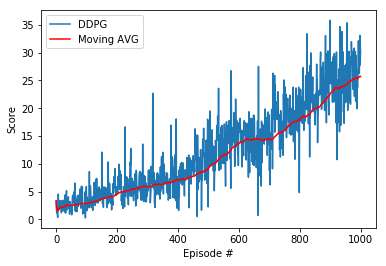

In [13]:
# Calculate Total Training Time
start_time = time.time()
# Keep the connection alive while training the model
with active_session():
    # Train Agent
    scores, avgs = ddpg()
# Training Time
time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [12]:
env.close()